#### Steps 


1. Create a function that takes a **tuple of two images** and returns a tuple of the same two cropped (or, equivalently, a patch from the) images, where the cropped images are of the same **randomly determined location**.

2. Verify that this was implemented correctly by visualizing the output images as in the previous module.  Create a class that inherits from **Dataset** to handle the NIfTI files. Implement the following methods:

```
  __init__
  __len__
  __getitem__
```

### Requirements

Please show evidence that the two classes/functions work as expected. For example, output an example from your Dataset class and plot slices from the output image pair (showing that they are from the same subject and align in space). Similarly, show that the crop function actually crops the image by printing the size of the output images and plotting an image pair output by this function.

### Resources

* https://liveproject.manning.com/module/103_3_1/3d-medical-image-analysis-with-pytorch/2--datasets-and-transforms/2-1--datasets-and-transforms?
* https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
* https://livebook.manning.com/book/deep-learning-with-pytorch/chapter-10/v-13/5
* https://nipy.org/nibabel/reference/nibabel.spatialimages.html

In [31]:
from torch.utils.data.dataset import Dataset
import nibabel as nib
from fnmatch import fnmatch
import os,re
import numpy as np

def load_mr_image(subj, ttype):
    suff = ttype.upper()
    if ttype == 't2': 
        suff = f'{suff}_reg'
    return nib.load(f'./data/small/{ttype}/{subj}-{suff}_fcm.nii.gz')

def path_to_subj(path):
    m = re.search(r"(IXI\d{3}-HH-\d{4})", path)
    return m.group(1)

class NiftiDataset(Dataset):
    """
    Extract images from the source (t1) and target (t2) directories
     
    Args:
        source: path to load source from
        target: path to load target from 
        transforms: trransforms to apply to both
    """
    def __init__(self, source_dir, target_dir, transform=None):
        
        # look in the directory and collect pairs of items. 
        t1_files = os.listdir(source_dir)
        t2_files = os.listdir(target_dir)

        self.subj_list = [ path_to_subj(e) for e in t1_files if fnmatch(e, r'*T1_fcm.nii.gz') ]        
        self.transform = transform
        
    def __len__(self):
        return len(self.subj_list)

    def __getitem__(self, idx):

        t1 = load_mr_image(self.subj_list[idx], "t1")
        t2 = load_mr_image(self.subj_list[idx], "t2")
        # TODO: should we automatically tranform np arrays to tensors? 
        sample = {'source': t1, 'target': t2}
        
        #could I run the transform on each individually?  Do I need my transform function to handle both?
        #technically the requirements call for a transform that works on a pair of images. 
        if self.transform:
            sample = self.transform(sample)
        
        return sample
        
    def byName(self, img_name):
        
        if re.search(r'nii.gz$', img_name):
            subj = path_to_subj(img_name)
        else:
            subj = img_name
            
        idx  = self.subj_list.index(subj)
        return self[idx]
        
#transform
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms
class RandomCrop3D:
    """Randomly crop randomly a 3D patch from images in an image pair.

    Args:
        output_size (tuple or int): Desired output size. If int, cube patch
            is made.
    """ 

    
    def __init__(self, output_size):
        assert isinstance(output_size, (int,tuple))
        if isinstance(output_size,int):
            self.output_size = (output_size, output_size, output_size)
        else:
            assert len(output_size)==3
            self.output_size = output_size

    #TODO: this function is now so small it's probably not worth keeping. 
    @staticmethod
    def crop(image, output_size, corners):
        
         #TODO: did I get the indexes right here? Might be L x H X W
        new_h, new_w, new_l = output_size
        top, left, front    = corners     
        
        # https://nipy.org/nibabel/reference/nibabel.spatialimages.html
        image = image.slicer[top:top+new_h, left:left+new_w, front:front+new_l]
        return image       
            
    def __call__(self, sample):
        
        assert sample['source'].shape[:3] == sample['target'].shape[:3]
        
        h,w,l = sample['source'].shape[:3]  
        new_h, new_w, new_l = self.output_size

        assert new_h < h and new_w < w and new_l < l
        
        top   = np.random.randint(0, h - new_h)
        left  = np.random.randint(0, w - new_w)
        front = np.random.randint(0, l - new_l)
        
        transformed = {}
        for i in ['source', 'target']:
            img_obj = sample[i]
            transformed[i] = RandomCrop3D.crop(img_obj, self.output_size, (top, left, front))
            
        return transformed
        


In [40]:
#plot your slice
import matplotlib.pyplot as plt
%matplotlib inline  


#imgs is a tuple
#dims is the size of the image you want to crop. 

def random_crop(imgs, dims):
    '''
    
    Args:
       imgs (tuple or str) : paths to two images
       dims (tuple or int) : dimensions to use for cropping the image. 
    '''
    cropped_dataset = NiftiDataset('./data/small/t1', './data/small/t2', RandomCrop3D(dims))
    
    #intentionally ignoring the second img argument. 
    if not str(imgs):
        imgs = imgs[0] 
    return cropped_dataset.byName(imgs)

def plot_crop_pair(img_pair, zidx):
    
    si = img_pair['source'].get_fdata()[:, :,zidx]
    ti = img_pair['target'].get_fdata()[:, :,zidx]
    
    plt.subplot(1, 2, 1)
    plt.imshow(si)
    plt.subplot(1, 2, 2)
    plt.imshow(ti)
    
    

In [43]:
t1t = 'data/small/t1/IXI159-HH-1549-T1_fcm.nii.gz'
cube_crop_dim = 60
rc = random_crop(t1t, cube_crop_dim)

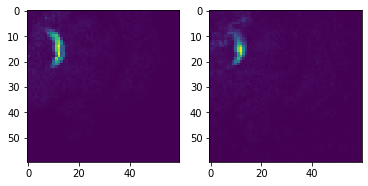

In [44]:
### plot some crops
zi = 2

plot_crop_pair(rc, zi)

### Testing Code

In [3]:
t2t = 'data/small/t2/IXI161-HH-2533-T2_reg_fcm.nii.gz'
t1t = 'data/small/t1/IXI159-HH-1549-T1_fcm.nii.gz'
print(path_to_subj(t2t))
print(path_to_subj(t1t))

IXI161-HH-2533
IXI159-HH-1549


In [4]:
ndl = NiftiDataset('./data/small/t1', './data/small/t2')

In [5]:
ndl.subj_list

['IXI167-HH-1569',
 'IXI161-HH-2533',
 'IXI180-HH-1605',
 'IXI128-HH-1470',
 'IXI168-HH-1607',
 'IXI162-HH-1548',
 'IXI159-HH-1549',
 'IXI127-HH-1451',
 'IXI174-HH-1571',
 'IXI131-HH-1527',
 'IXI148-HH-1453',
 'IXI102-HH-1416',
 'IXI137-HH-1472',
 'IXI176-HH-1604',
 'IXI165-HH-1589',
 'IXI132-HH-1415',
 'IXI195-HH-1620',
 'IXI150-HH-1550',
 'IXI175-HH-1570',
 'IXI126-HH-1437',
 'IXI105-HH-1471',
 'IXI163-HH-1621',
 'IXI104-HH-1450',
 'IXI160-HH-1637',
 'IXI173-HH-1590',
 'IXI146-HH-1389',
 'IXI130-HH-1528',
 'IXI136-HH-1452']

In [8]:
s = ndl[4]
s['source']

In [55]:
print(len(ndl))

28
